In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

# 07 Milestone Project 1: 🍔👁 Food Vision Big

In the previous notebook we built Food Vision mini: a transfer learning model which beat the original results of the [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) with only 10% of the data.

We're going to be building Food Vision Big using all of the data from the Food101 dataset.

All 75,750 training images and 25,250 testing images.

This time **we've got the goal of beating [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment)**, a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.

> 🔑 **Note:** **Top-1 accuracy** means "accuracy for the top softmax activation value output by the model" (because softmax ouputs a value for every class, but top-1 means only the highest one is evaluated). **Top-5 accuracy** means "accuracy for the top 5 softmax activation values output by the model", in other words, did the true label appear in the top 5 activation values? Top-5 accuracy scores are usually noticeably higher than top-1.

|  | 🍔👁 Food Vision Big™ | 🍔👁 Food Vision mini |
|-----|-----|-----|
| Dataset source | TensorFlow Datasets | Preprocessed download from Kaggle | 
| Train data | 75,750 images | 7,575 images | 
| Test data | 25,250 images | 25,250 images | 
| Mixed precision | Yes | No |
| Data loading | Performanant tf.data API | TensorFlow pre-built function |  
| Target results | 77.4% top-1 accuracy (beat [DeepFood paper](https://arxiv.org/abs/1606.05675)) | 50.76% top-1 accuracy (beat [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)) | 

*Table comparing difference between Food Vision Big (this notebook) versus Food Vision mini (previous notebook).*

Alongside attempting to beat the DeepFood paper, we're going to learn about two methods to significantly improve the speed of our model training:
1. Prefetching
2. Mixed precision training

## What we're going to cover

* Using TensorFlow Datasets to download and explore data
* Creating preprocessing function for our data
* Batching & preparing datasets for modelling (**making our datasets run fast**)
* Creating modelling callbacks
* Setting up **mixed precision training**
* Building a feature extraction model
* Fine-tuning the feature extraction model
* Viewing training results on TensorBoard.


In [2]:
# Getting Helper Functions:
import wget

url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"
file = wget.download(url)

In [3]:
from helper_functions import create_tensorboard_callback, compare_historys, plot_loss_curves

## Use TensorFlow Datasets to Download Data

In previous notebooks, we've downloaded our food images (from the [Food101 dataset](https://www.kaggle.com/dansbecker/food-101/home)) from Google Storage.

And this is a typical workflow you'd use if you're working on your own datasets.

However, there's another way to get datasets ready to use with TensorFlow.

For many of the most popular datasets in the machine learning world (often referred to and used as benchmarks), you can access them through [TensorFlow Datasets (TFDS)](https://www.tensorflow.org/datasets/overview).

What is **TensorFlow Datasets**?

A place for prepared and ready-to-use machine learning datasets.

Why use TensorFlow Datasets?

* Load data already in Tensors
* Practice on well established datasets
* Experiment with differet data loading techniques (like we're going to use in this notebook)
* Experiment with new TensorFlow features quickly (such as mixed precision training)

Why *not* use TensorFlow Datasets?

* The datasets are static (they don't change, like your real-world datasets would)
* Might not be suited for your particular problem (but great for experimenting)

To begin using TensorFlow Datasets we can import it under the alias `tfds`.

In [4]:
# Get Tensorflow Datasets:
!pip install tensorflow_datasets --user

In [5]:
import tensorflow_datasets as tfds

To find all of the available datasets in TensorFlow Datasets, you can use the `list_builders()` method.

After doing so, we can check to see if the one we're after (`"food101"`) is present.

In [6]:
datasets_list = tfds.list_builders()

In [7]:
datasets_list[:10]

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence']

In [8]:
"food101" in datasets_list

True

To get access to the Food101 dataset from the TFDS, we can use the [`tfds.load()`](https://www.tensorflow.org/datasets/api_docs/python/tfds/load) method.

In particular, we'll have to pass it a few parameters to let it know what we're after:
* `name` (str) : the target dataset (e.g. `"food101"`)
* `split` (list, optional) : what splits of the dataset we're after (e.g. `["train", "validation"]`)
  * the `split` parameter is quite tricky. See [the documentation for more](https://github.com/tensorflow/datasets/blob/master/docs/splits.md).
* `shuffle_files` (bool) : whether or not to shuffle the files on download, defaults to `False` 
* `as_supervised` (bool) : `True` to download data samples in tuple format (`(data, label)`) or `False` for dictionary format 
* `with_info` (bool) : `True` to download dataset metadata (labels, number of samples, etc)

> 🔑 **Note:** Calling the `tfds.load()` method will start to download a target dataset to disk if the `download=True` parameter is set (default). This dataset could be 100GB+, so make sure you have space.

In [9]:
# Load in Data:

(train_data, test_data), ds_info = tfds.load(name= "food101", # target dataset to get from TFDS
                                            split= ["train","validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                            as_supervised= True, # download data in tuple format (sample, label), e.g. (image, label)
                                            shuffle_files= True, # shuffle files on download?
                                            with_info= True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

After a few minutes of downloading, we've now got access to entire Food101 dataset (in tensor format) ready for modelling.

Now let's get a little information from our dataset, starting with the class names.

Getting class names from a TensorFlow Datasets dataset requires downloading the "`dataset_info`" variable (by using the `as_supervised=True` parameter in the `tfds.load()` method, **note:** this will only work for supervised datasets in TFDS).

We can access the class names of a particular dataset using the `dataset_info.features` attribute and accessing `names` attribute of the the `"label"` key.

In [10]:
# Features of "food101":
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [11]:
type(ds_info)

tensorflow_datasets.core.dataset_info.DatasetInfo

In [12]:
# Get Class Names:
class_names = ds_info.features["label"].names

In [13]:
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### Exploring the Food101 data from TensorFlow Datasets

Now we've downloaded the Food101 dataset from TensorFlow Datasets, let's explore it.

Let's find out a few details about our dataset:
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
* Do the labels match up with the class names?

To do, let's take one sample off the training data (using the [`.take()` method](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take)) and explore it. 

In [14]:
# Take One Sample from Training Data:
train_one_sample = train_data.take(1)

Because we used the `as_supervised=True` parameter in our `tfds.load()` method above, data samples come in the tuple format structure `(data, label)` or in our case `(image_tensor, label)`.

In [15]:
# What Does One Sample from Training Data Look Like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Let's loop through our single training sample and get some info from the `image_tensor` and `label`.

In [16]:
# Outpuut info about One Training Sample:
for image, label in train_one_sample:
    print(f"""
    Image Shape: {image.shape}
    Image DataType: {image.dtype}
    Target Class from Food101 (Tensor form): {label}
    Class Name (Str form): {class_names[label.numpy()]}
    """)


    Image Shape: (512, 512, 3)
    Image DataType: <dtype: 'uint8'>
    Target Class from Food101 (Tensor form): 23
    Class Name (Str form): churros
    


Because we set the `shuffle_files=True` parameter in our `tfds.load()` method above, running the cell above a few times will give a different result each time.

Checking these you might notice some of the images have different shapes, for example `(512, 342, 3)` and `(512, 512, 3)` (height, width, color_channels).

Let's see what one of the image tensors from TFDS's Food101 dataset looks like.

In [17]:
# What Does an Image Tensor from TFDS' FOOD101 looks like:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[189, 165, 121],
        [185, 161, 117],
        [181, 157, 113],
        ...,
        [111,  72,  33],
        [103,  64,  25],
        [ 94,  55,  16]],

       [[186, 162, 118],
        [183, 159, 115],
        [180, 156, 112],
        ...,
        [122,  83,  40],
        [113,  74,  31],
        [105,  66,  23]],

       [[180, 156, 112],
        [178, 154, 110],
        [177, 153, 109],
        ...,
        [132,  94,  45],
        [124,  87,  35],
        [120,  83,  31]],

       ...,

       [[207, 204, 159],
        [205, 201, 154],
        [204, 196, 147],
        ...,
        [231, 225, 191],
        [231, 225, 189],
        [231, 226, 188]],

       [[207, 204, 159],
        [205, 201, 154],
        [204, 196, 147],
        ...,
        [230, 224, 190],
        [230, 224, 188],
        [229, 223, 187]],

       [[206, 203, 158],
        [204, 200, 153],
        [203, 195, 146],
        ...,
        [229, 223, 18

In [18]:
import tensorflow as tf

In [19]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Alright looks like our image tensors have values of between 0 & 255 (standard red, green, blue colour values) and the values are of data type `unit8`.

We might have to preprocess these before passing them to a neural network. But we'll handle this later.

In the meantime, let's see if we can plot an image sample.

### Plot an image from TensorFlow Datasets

Let's plot one of the image samples using [`matplotlib.pyplot.imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) and set the title to target class name.

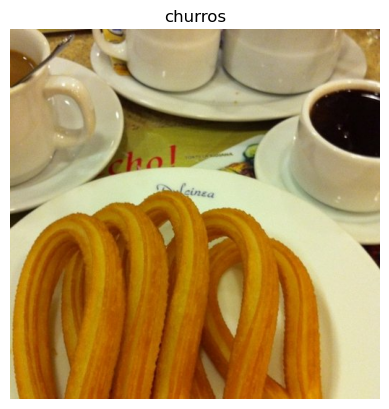

In [20]:
# Plot The Image from Training Data:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)
plt.show()

## Create preprocessing functions for our data

In previous notebooks, when our images were in folder format we used the method [`tf.keras.utils.image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) to load them in.

Doing this meant our data was loaded into a format ready to be used with our models.

However, since we've downloaded the data from TensorFlow Datasets, there are a couple of preprocessing steps we have to take before it's ready to model. 

More specifically, our data is currently:

* In `uint8` data type
* Comprised of all differnet sized tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

Whereas, models like data to be:

* In `float32` data type
* Have all of the same size tensors (batches require all tensors have the same shape, e.g. `(224, 224, 3)`)
* Scaled (values between 0 & 1), also called normalized

To take care of these, we'll create a `preprocess_img()` function which:

* Resizes an input image tensor to a specified size using [`tf.image.resize()`](https://www.tensorflow.org/api_docs/python/tf/image/resize)
* Converts an input image tensor's current datatype to `tf.float32` using [`tf.cast()`](https://www.tensorflow.org/api_docs/python/tf/cast)

Pretrained EfficientNetBX models in [`tf.keras.applications.efficientnet`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet) (what we're going to be using) have rescaling built-in. But for many other model architectures you'll want to rescale your data (e.g. get its values between 0 & 1). This could be incorporated inside your "`preprocess_img()`" function (like the one below) or within your model as a [`tf.keras.layers.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) layer.

In [21]:
# Function to Pre-Process Images:
def preprocess_image(image, label, image_shape= 224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [image_shape, image_shape, color_channels]
    """
    image = tf.image.resize(images= image, size= [image_shape, image_shape]) # reshape to image_shape
    return tf.cast(image, dtype= tf.float32), label # return (float32_image, label) tuple

Our `preprocess_img()` function above takes image and label as input (even though it does nothing to the label) because our dataset is currently in the tuple structure `(image, label)`.

Let's try our function out on a target image.

In [22]:
# Pre-Process a Single Image:
preprocessed_image = preprocess_image(image, label)[0]
print(f"Image Before Pre-Processing\n: {image[:2]}... \nShape: {image.shape}... \nDataType: {image.dtype}\n")
print(f"Image After Pre-Processing\n: {preprocessed_image[:2]}... \nShape: {preprocessed_image.shape}... \nDataType: {preprocessed_image.dtype}")

Image Before Pre-Processing
: [[[189 165 121]
  [185 161 117]
  [181 157 113]
  ...
  [111  72  33]
  [103  64  25]
  [ 94  55  16]]

 [[186 162 118]
  [183 159 115]
  [180 156 112]
  ...
  [122  83  40]
  [113  74  31]
  [105  66  23]]]... 
Shape: (512, 512, 3)... 
DataType: <dtype: 'uint8'>

Image After Pre-Processing
: [[[184.91327  160.91327  116.91326 ]
  [180.35715  156.35715  112.35714 ]
  [183.71428  160.71428  118.71429 ]
  ...
  [147.5915   108.66289   69.08129 ]
  [123.576454  84.576454  44.198887]
  [106.44359   67.44359   25.872158]]

 [[174.66837  150.66837  106.668365]
  [175.14285  151.14285  107.14286 ]
  [177.80103  153.22958  112.015305]
  ...
  [155.61722  119.545784  68.443695]
  [145.1989   108.19381   53.423363]
  [134.37747   98.30605   40.73462 ]]]... 
Shape: (224, 224, 3)... 
DataType: <dtype: 'float32'>


## Batch & prepare datasets

Before we can model our data, we have to turn it into batches.

Why?

Because computing on batches is memory efficient.

We turn our data from 101,000 image tensors and labels (train and test combined) into batches of 32 image and label pairs, thus enabling it to fit into the memory of our GPU.

To do this in effective way, we're going to be leveraging a number of methods from the [`tf.data` API](https://www.tensorflow.org/api_docs/python/tf/data).

For loading data in the most performant way possible, see the TensorFlow docuemntation on [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance).

Specifically, we're going to be using:

* [`map()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) - maps a predefined function to a target dataset (e.g. `preprocess_img()` to our image tensors)
* [`shuffle()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) - randomly shuffles the elements of a target dataset up `buffer_size` (ideally, the `buffer_size` is equal to the size of the dataset, however, this may have implications on memory)
* [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) - turns elements of a target dataset into batches (size defined by parameter `batch_size`)
* [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but costs memory)
* Extra: [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) - caches (saves them for later) elements in a target dataset, saving loading time (will only work if your dataset is small enough to fit in memory, standard Colab instances only have 12GB of memory) 

Things to note:
- Can't batch tensors of different shapes (e.g. different image sizes, need to reshape images first, hence our `preprocess_img()` function)
- `shuffle()` keeps a buffer of the number you pass it images shuffled, ideally this number would be all of the samples in your training set, however, if your training set is large, this buffer might not fit in memory (a fairly large number like 1000 or 10000 is usually suffice for shuffling)
- For methods with the `num_parallel_calls` parameter available (such as `map()`), setting it to`num_parallel_calls=tf.data.AUTOTUNE` will parallelize preprocessing and significantly improve speed
- Can't use `cache()` unless your dataset can fit in memory

Woah, the above is alot. But once we've coded below, it'll start to make sense.

We're going to through things in the following order:

```
Original dataset (e.g. train_data) -> map() -> shuffle() -> batch() -> prefetch() -> PrefetchDataset
```

This is like saying, 

"Hey, map this preprocessing function across our training dataset, then shuffle a number of elements before batching them together and make sure you prepare new batches (prefetch) whilst the model is looking through the current batch".

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-prefetching-from-hands-on-ml.png)

*What happens when you use prefetching (faster) versus what happens when you don't use prefetching (slower). **Source:** Page 422 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/).

In [23]:
# Map Pre-Processing Function to Training Data (and Paralellize):
train_data = train_data.map(map_func= preprocess_image, num_parallel_calls= tf.data.AUTOTUNE)

# Shuffle Training Data and Turn it into Batches and Pre-Fetch it (Load it Faster):
train_data = train_data.shuffle(buffer_size= 1000).batch(batch_size= 32).prefetch(buffer_size= tf.data.AUTOTUNE)

# Map Pre-Processing Function to Test Data:
test_data = test_data.map(map_func= preprocess_image, num_parallel_calls= tf.data.AUTOTUNE)

# Turn Test Data into Batches (No Need to Shuffle):
test_data = test_data.batch(batch_size= 32).prefetch(buffer_size= tf.data.AUTOTUNE)

In [24]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks

Since we're going to be training on a large amount of data and training could take a long time, it's a good idea to set up some modelling callbacks so we be sure of things like our model's training logs being tracked and our model being checkpointed (saved) after various training milestones.

To do each of these we'll use the following callbacks:
* [`tf.keras.callbacks.TensorBoard()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) - allows us to keep track of our model's training history so we can inspect it later (**note:** we've created this callback before have imported it from `helper_functions.py` as `create_tensorboard_callback()`)
* [`tf.keras.callbacks.ModelCheckpoint()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - saves our model's progress at various intervals so we can load it and resuse it later without having to retrain it
* Checkpointing is also helpful so we can start fine-tuning our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits

In [26]:
# Creating TensorBoard Callback (Using Function already Created in Helper Functions):
from helper_functions import create_tensorboard_callback

# Creating Model Checkpoint Callback to Save Model's Progress:
checkpoint_path = "model_checkpoints\\cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath= checkpoint_path,
                                                     monitor= "val_acc",
                                                     save_best_only= True,
                                                     save_weights_only= True,
                                                     verbose= 0)

## Setup mixed precision training

Normally, tensors in TensorFlow default to the float32 datatype (unless otherwise specified).

In computer science, float32 is also known as [single-precision floating-point format](https://en.wikipedia.org/wiki/Single-precision_floating-point_format). The 32 means it usually occupies 32 bits in computer memory.

Your GPU has a limited memory, therefore it can only handle a number of float32 tensors at the same time.

This is where mixed precision training comes in.

Mixed precision training involves using a mix of float16 and float32 tensors to make better use of your GPU's memory.

Can you guess what float16 means?

Well, if you thought since float32 meant single-precision floating-point, you might've guessed float16 means [half-precision floating-point format](https://en.wikipedia.org/wiki/Half-precision_floating-point_format). And if you did, you're right! And if not, no trouble, now you know.

For tensors in float16 format, each element occupies 16 bits in computer memory.

So, where does this leave us?

As mentioned before, when using mixed precision training, your model will make use of float32 and float16 data types to use less memory where possible and in turn run faster (using less memory per tensor means more tensors can be computed on simultaneously).

As a result, using mixed precision training can improve your performance on modern GPUs (those with a compute capability score of 7.0+) by up to 3x.

For a more detailed explanation, I encourage you to read through the [TensorFlow mixed precision guide](https://www.tensorflow.org/guide/mixed_precision) (I'd highly recommend at least checking out the summary).

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-mixed-precision-speedup-equals-3x-gpu.png)
*Because mixed precision training uses a combination of float32 and float16 data types, you may see up to a 3x speedup on modern GPUs.*

If your GPU doesn't have a score of over 7.0+ (e.g. P100 in Google Colab), mixed precision won't work (see: ["Supported Hardware"](https://www.tensorflow.org/guide/mixed_precision#supported_hardware) in the mixed precision guide for more).

If you'd like to learn more about precision in computer science (the detail to which a numerical quantity is expressed by a computer), see the [Wikipedia page](https://en.wikipedia.org/wiki/Precision_(computer_science)) (and accompanying resources). 


The beautiful thing is, the [`tensorflow.keras.mixed_precision`](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/) API has made it very easy for us to get started.

First, we'll import the API and then use the [`set_global_policy()`](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/set_global_policy) method to set the *dtype policy* to `"mixed_float16"`.

In [27]:
# Turn on Mixed Precision Training:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy= "mixed_float16") # set global policy to mixed precision 

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [28]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

Let's build a model.

Because our dataset is quite large, we're going to move towards fine-tuning an existing pretrained model (EfficienetNetB0).

But before we get into fine-tuning, let's set up a feature-extraction model.

Recall, the typical order for using transfer learning is:

1. Build a feature extraction model (replace the top few layers of a pretrained model) 
2. Train for a few epochs with lower layers frozen
3. Fine-tune if necessary with multiple layers unfrozen

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-feature-extraction-then-fine-tune.png)
*Before fine-tuning, it's best practice to train a feature extraction model with custom top layers.*

To build the feature extraction model, we'll:
* Use `EfficientNetB0` from [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) pre-trained on ImageNet as our base model
  * We'll download this without the top layers using `include_top=False` parameter so we can create our own output layers
* Freeze the base model layers so we can use the pre-learned patterns the base model has found on ImageNet
* Put together the input, base model, pooling and output layers in a [Functional model](https://keras.io/guides/functional_api/)
* Compile the Functional model using the Adam optimizer and [sparse categorical crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) as the loss function (since our labels **aren't** one-hot encoded)
* Fit the model for 3 epochs using the TensorBoard and ModelCheckpoint callbacks

 Since we're using mixed precision training, our model needs a separate output layer with a hard-coded `dtype=float32`, for example, `layers.Activation("softmax", dtype=tf.float32)`. This ensures the outputs of our model are returned back to the float32 data type which is more numerically stable than the float16 datatype (important for loss calculations). See the ["Building the model"](https://www.tensorflow.org/guide/mixed_precision#building_the_model) section in the TensorFlow mixed precision guide for more.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-mixed-precision-code-before-and-after.png)
*Turning mixed precision on in TensorFlow with 3 lines of code.*

In [29]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Activation, GlobalAveragePooling2D, Input, Rescaling
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [30]:
# Building Feature Extraction Model:

# Creating The Base Model:
input_shape= (224,224,3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top= False)
base_model.trainable= False

# Creating Functional Model:
inputs = Input(shape= input_shape, name= "Input_Layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(inputs)
x = base_model(inputs, training= False) # set base_model to inference mode only
x = GlobalAveragePooling2D(name= "Global_Average_Pooling_Layer")(x)
x = Dense(len(class_names))(x) # want one output neuron per class 
outputs = Activation(activation= "softmax", dtype= tf.float32, name= "Softmax_Float32")(x)
model = Model(inputs, outputs)

# Compile The Model:
model.compile(optimizer= Adam(),
             loss= SparseCategoricalCrossentropy(),
             metrics= ["accuracy"])

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 Global_Average_Pooling_Lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 Softmax_Float32 (Activatio  (None, 101)               0         
 n)                                                          

## Checking layer dtype policies (are we using mixed precision?)

The mixed precision API will automatically change our layers' dtype policy's to whatever the global dtype policy is (in our case it's `"mixed_float16"`).

We can check this by iterating through our model's layers and printing layer attributes such as `dtype` and `dtype_policy`.

In [32]:
# Checking Layer Dtype Policies:
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

Input_Layer True float32 <Policy "float32">
efficientnetv2-b0 False float32 <Policy "mixed_float16">
Global_Average_Pooling_Layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
Softmax_Float32 True float32 <Policy "float32">


Going through the above we see:
* `layer.name` (str) : a layer's human-readable name, can be defined by the `name` parameter on construction
* `layer.trainable` (bool) : whether or not a layer is trainable (all of our layers are trainable except the efficientnetb0 layer since we set it's `trainable` attribute to `False`
* `layer.dtype` : the data type a layer stores its variables in
* `layer.dtype_policy` : the data type a layer computes in

A layer can have a dtype of `float32` and a dtype policy of `"mixed_float16"` because it stores its variables (weights & biases) in `float32` (more numerically stable), however it computes in `float16` (faster).

We can also check the same details for our model's base model.

In [33]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:15]: # only check the first 15 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block1a_project_activation False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <Policy "mixed_float16">
block2a_expand_activation False float32 <Policy "mixed_float16">
block2a_project_conv False float32 <Policy "mixed_float16">
block2a_project_bn False float32 <Policy "mixed_float16">
block2b_expand_conv False float32 <Policy "mixed_float16">


## Fit the feature extraction model

Three epochs should be enough for our top layers to adjust their weights enough to our food image data.

To save time per epoch, we'll also only validate on 15% of the test data.

In [35]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fitting The Feature Extraction Model:

history_101_food_classes_feature_extraction = model.fit(train_data,
                                                       validation_data= test_data,
                                                       epochs= 3,
                                                       validation_steps= int(0.15 * len(test_data)),
    callbacks= [create_tensorboard_callback(dir_name= "training_logs_MileStone1", 
                            experiment_name= "efficientnetb0_101_classes_all_data_feature_extract"),
               model_checkpoint])

Saving TensorBoard log files to: training_logs_MileStone1/efficientnetb0_101_classes_all_data_feature_extract/20240515-125055
Epoch 1/3
2368/2368 [==============================] - 1517s 636ms/step - loss: 1.7434 - accuracy: 0.5779 - val_loss: 1.1395 - val_accuracy: 0.7018
Epoch 2/3
2368/2368 [==============================] - 1449s 612ms/step - loss: 1.2106 - accuracy: 0.6876 - val_loss: 1.0326 - val_accuracy: 0.7238
Epoch 3/3
2368/2368 [==============================] - 1474s 623ms/step - loss: 1.0633 - accuracy: 0.7219 - val_loss: 0.9914 - val_accuracy: 0.7354


In [36]:
# Evaluating Model on Whole Test Data:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 468s 592ms/step - loss: 0.9951 - accuracy: 0.7304


[0.9950719475746155, 0.7303762435913086]

## Preparing our model's layers for fine-tuning

Our feature-extraction model is showing some great promise after three epochs. But since we've got so much data, it's probably worthwhile that we see what results we can get with fine-tuning (fine-tuning usually works best when you've got quite a large amount of data).

Remember our goal of beating the [DeepFood paper](https://arxiv.org/pdf/1606.05675.pdf)?

They were able to achieve 77.4% top-1 accuracy on Food101 over 2-3 days of training.


It's worth remembering a traditional workflow for fine-tuning is to freeze a pre-trained base model and then train only the output layers for a few iterations so their weights can be updated inline with your custom data (feature extraction). And then unfreeze a number or all of the layers in the base model and continue training until the model stops improving.

In [45]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 Global_Average_Pooling_Lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 Softmax_Float32 (Activatio  (None, 101)               0         
 n)                                                          

In [46]:
# How many Frozen Layers are there in The Model:

for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

Input_Layer True float32 <Policy "float32">
efficientnetv2-b0 False float32 <Policy "mixed_float16">
Global_Average_Pooling_Layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
Softmax_Float32 True float32 <Policy "float32">


It seems like each layer in our loaded model is trainable. But what if we got a little deeper and inspected each of the layers in our base model?

*Which layer in the loaded model is our base model?*

We created it with five layers (layers below are 0-indexed):
0. The input layer
1. The pre-trained base model layer ([`tf.keras.applications.efficientnet.EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0))
2. The pooling layer
3. The fully-connected (dense) layer
4. The output softmax activation (with float32 dtype)

Therefore to inspect our base model layer, we can access the `layers` attribute of the layer at index 1 in our model.

In [48]:
# Checking for Frozen Layers in Base Model:
for layer in model.layers[1].layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block1a_project_activation False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <Policy "mixed_float16">
block2a_expand_activation False float32 <Policy "mixed_float16">
block2a_project_conv False float32 <Policy "mixed_float16">
block2a_project_bn False float32 <Policy "mixed_float16">
block2b_expand_conv False float32 <Policy "mixed_float16">
block2b_expand_bn False float32 <Policy "mixed_float16">
block2b_expand_activation False float32 <Policy "mixed_float16">
block2b_project_conv False float32 <Policy

In [49]:
# Making All The Layers of Our Base Model Trainable (Unfrozen):

for layer in model.layers[1].layers:
    layer.trainable= True # set all layers to trainable

In [50]:
# Checking for Frozen Layers in Base Model:
for layer in model.layers[1].layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block1a_project_activation True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float16">
block2a_expand_activation True float32 <Policy "mixed_float16">
block2a_project_conv True float32 <Policy "mixed_float16">
block2a_project_bn True float32 <Policy "mixed_float16">
block2b_expand_conv True float32 <Policy "mixed_float16">
block2b_expand_bn True float32 <Policy "mixed_float16">
block2b_expand_activation True float32 <Policy "mixed_float16">
block2b_project_conv True float32 <Policy "mixed_float16">


It looks like each layer in our base model is trainable (unfrozen) and every layer which should be using the dtype policy `"mixed_policy16"` is using it.

Since we've got so much data (750 images x 101 training classes = 75750 training images), let's keep all of our base model's layers unfrozen.

If you've got a small amount of data (less than 100 images per class), you may want to only unfreeze and fine-tune a small number of layers in the base model at a time. Otherwise, you risk overfitting.

## A couple more callbacks

We're about to start fine-tuning a deep learning model with over 200 layers using over 100,000 (75k+ training, 25K+ testing) images, which means our model's training time is probably going to be much longer than before.

Question: *How long does training take?*

It could be a couple of hours or in the case of the [DeepFood paper](https://arxiv.org/pdf/1606.05675.pdf) (the baseline we're trying to beat), their best performing model took 2-3 days of training time.

You will really only know how long it'll take once you start training.

Question: *When do you stop training?*

Ideally, when your model stops improving. But again, due to the nature of deep learning, it can be hard to know when exactly a model will stop improving.

Luckily, there's a solution: the [`EarlyStopping` callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).

The `EarlyStopping` callback monitors a specified model performance metric (e.g. `val_loss`) and when it stops improving for a specified number of epochs, automatically stops training. 

Using the `EarlyStopping` callback combined with the `ModelCheckpoint` callback saving the best performing model automatically, we could keep our model training for an unlimited number of epochs until it stops improving.

Let's set both of these up to monitor our model's `val_loss`.

In [51]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stop = tf.keras.callbacks.EarlyStopping(monitor= "val_loss", # watch the val loss metric
                                             patience= 3) # if val loss does not decrease for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints\\"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath= checkpoint_path,
                                                     save_best_only= True,
                                                     monitor= "val_loss")

We're almost ready to start fine-tuning our model but there's one more callback we're going to implement: [`ReduceLROnPlateau`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau).

Remember how the learning rate is the most important model hyperparameter you can tune? (if not, treat this as a reminder).

Well, the `ReduceLROnPlateau` callback helps to tune the learning rate for you.

Like the `ModelCheckpoint` and `EarlyStopping` callbacks, the `ReduceLROnPlateau` callback montiors a specified metric and when that metric stops improving, it reduces the learning rate by a specified factor (e.g. divides the learning rate by 10).

> 🤔 **Question:** *Why lower the learning rate?*

Imagine having a coin at the back of the couch and you're trying to grab with your fingers. 

Now think of the learning rate as the size of the movements your hand makes towards the coin. 

The closer you get, the smaller you want your hand movements to be, otherwise the coin will be lost.

Our model's ideal performance is the equivalent of grabbing the coin. So as training goes on and our model gets closer and closer to it's ideal performance (also called **convergence**), we want the amount it learns to be less and less.

To do this we'll create an instance of the `ReduceLROnPlateau` callback to monitor the validation loss just like the `EarlyStopping` callback. 

Once the validation loss stops improving for two or more epochs, we'll reduce the learning rate by a factor of 5 (e.g. `0.001` to `0.0002`).

And to make sure the learning rate doesn't get too low (and potentially result in our model learning nothing), we'll set the minimum learning rate to `1e-7`.

In [52]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor= "val_loss",
                                                 factor= 0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience= 2,
                                                 verbose= 1, # print out when learning rate goes down
                                                 min_lr= 1e-7)

Now before we start training, we've got to recompile our model.

We'll use sparse categorical crossentropy as the loss and since we're fine-tuning, we'll use a 10x lower learning rate than the Adam optimizers default (`1e-4` instead of `1e-3`).

In [53]:
# Compile The Model:
model.compile(optimizer= Adam(0.0001), # 10x lower learning rate than the default
             loss= SparseCategoricalCrossentropy(), # sparse_categorical_crossentropy for labels that are *not* one-hot
             metrics= ["accuracy"])

Now let's fit it on all of the data. 

We'll set it up to run for up to 50 epochs. 

Since we're going to be using the `EarlyStopping` callback, it might stop before reaching 50 epochs.

Running the cell below will set the model up to fine-tune all of the pre-trained weights in the base model on all of the Food101 data. Doing so with **unoptimized** data pipelines and **without** mixed precision training will take a fairly long time per epoch depending on what type of GPU you're using (about 15-20 minutes on Colab GPUs). But don't worry, **the code we've written above will ensure it runs much faster** (more like 4-5 minutes per epoch).

In [56]:
# Fitting And Fine Tuning The Model:
history_101_food_classes_fine_tune = model.fit(train_data,
                                              validation_data= test_data,
                                              epochs= 50,
                                              initial_epoch= history_101_food_classes_feature_extraction.epoch[-1],
                                              validation_steps= int(0.15 * len(test_data)),
    callbacks= [create_tensorboard_callback(dir_name= "training_logs_MileStone1", 
                    experiment_name= "efficientnetb0_101_classes_all_data_fine_tune"), # track the model training logs
               model_checkpoint, # save only the best model during training
                early_stop, # stop model after X epochs of no improvements
               reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs_MileStone1/efficientnetb0_101_classes_all_data_fine_tune/20240515-150119
Epoch 3/50
2368/2368 [==============================] - 1777s 750ms/step - loss: 0.8983 - accuracy: 0.7709 - val_loss: 0.9554 - val_accuracy: 0.7460 - lr: 1.0000e-04
Epoch 4/50
2368/2368 [==============================] - 1524s 643ms/step - loss: 0.8863 - accuracy: 0.7745 - val_loss: 0.9588 - val_accuracy: 0.7476 - lr: 1.0000e-04
Epoch 5/50
2368/2368 [==============================] - ETA: 0s - loss: 0.8768 - accuracy: 0.7773
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 1607s 679ms/step - loss: 0.8768 - accuracy: 0.7773 - val_loss: 0.9586 - val_accuracy: 0.7474 - lr: 1.0000e-04
Epoch 6/50
2368/2368 [==============================] - 1556s 657ms/step - loss: 0.8610 - accuracy: 0.7828 - val_loss: 0.9550 - val_accuracy: 0.7474 - lr: 2.0000e-05
Epoch 7/50
2368/2368 [==============================

In [57]:
# Evaluating Model on Whole test Data:
results_fine_tune = model.evaluate(test_data)
results_fine_tune

790/790 [==============================] - 409s 518ms/step - loss: 0.9477 - accuracy: 0.7448


[0.9477353692054749, 0.7447524666786194]

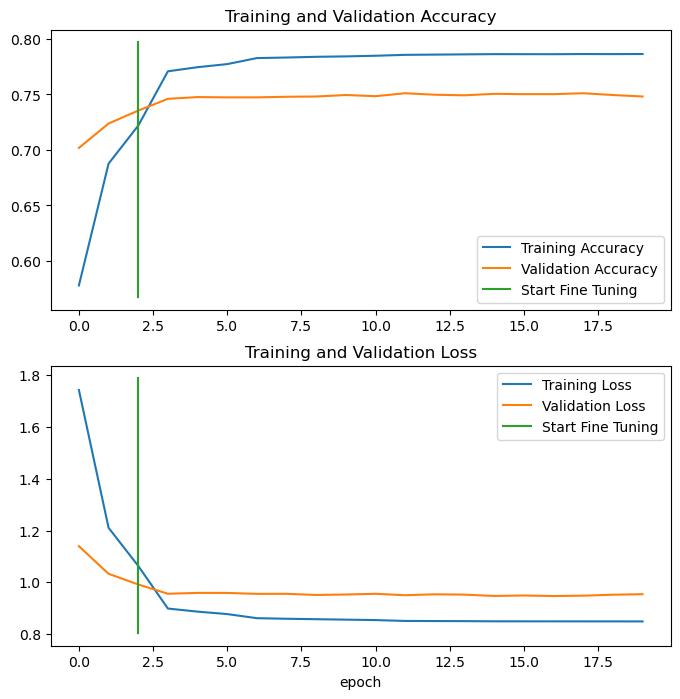

In [58]:
# Comparing Model Histories for Feature Extraction and After Fine Tuning:
compare_historys(original_history= history_101_food_classes_feature_extraction,
                 new_history= history_101_food_classes_fine_tune,
                 initial_epochs= 3)